In [16]:
import random
from collections import defaultdict
from itertools import combinations, product, chain

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx

from agent import Student, Course
from matching import *
from simulate import * 

%matplotlib inline

There are $m$ students, $n$ courses, and $d$ departments.

Students may come from any of the $4$ class years: freshmen, sophomores, juniors, and seniors. Randomly assign the students to these four class years. In addition, randomly assign the students to the departments.

The courses may come from any of the $d$ departments. Randomly assign the courses to the departments (may have higher sampling weights for courses in the department that the student is in)

Next, generate random preference orders for students: rankings of the $n$ courses.

Also, generate preference orders over students for the courses in the following manner: courses prefer students from their own department, prefer students from higher class years than lower class years; in case of ties, break arbitrarily.


TODO: Need to define utilities of students

linear utility in the order of preferences

In [17]:
student_list, course_list = generate_data(n_students = 5000, n_courses = 100, n_depts = 15, 
                                          credit_limit = 4, enroll_limit = 80)

# Student-proposing DA

Suppose $credit\_limit = 4$ for each student and $enroll\_limit = 80$.

In each round, a student $s$ proposes to their $credit\_limit$ most preferred courses. Then, the courses tentatively accept their $enroll\_limit$ most preferred students and reject the rest.

Students cannot propose to courses that they have been rejected. And courses only tentatively accept students that are more highly preferred. 

Repeat until no more proposal can be made

TODO: need assumption over the preferences (e.g. substitutability)

In [18]:
student_list, course_list = find_matching(student_list, course_list)

Round: 1
	Number of proposals made: 20000
	Number of proposals being rejected: 12000
Round: 2
	Number of proposals made: 12000
	Number of proposals being rejected: 12000
Round: 3
	Number of proposals made: 12000
	Number of proposals being rejected: 12000
Round: 4
	Number of proposals made: 12000
	Number of proposals being rejected: 12000
Round: 5
	Number of proposals made: 12000
	Number of proposals being rejected: 12000
Round: 6
	Number of proposals made: 12000
	Number of proposals being rejected: 12000
Round: 7
	Number of proposals made: 12000
	Number of proposals being rejected: 12000
Round: 8
	Number of proposals made: 12000
	Number of proposals being rejected: 12000
Round: 9
	Number of proposals made: 12000
	Number of proposals being rejected: 12000
Round: 10
	Number of proposals made: 12000
	Number of proposals being rejected: 12000
Round: 11
	Number of proposals made: 12000
	Number of proposals being rejected: 12000
Round: 12
	Number of proposals made: 12000
	Number of proposals

Text(0.5, 0, 'Student utiltities')

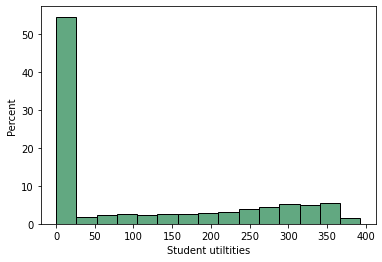

In [19]:
student_utilities = [s.get_utilities() for s in student_list]
sns.histplot(student_utilities, stat = 'percent', color = 'seagreen')
plt.xlabel("Student utiltities")

Text(0.5, 0, 'Course sizes')

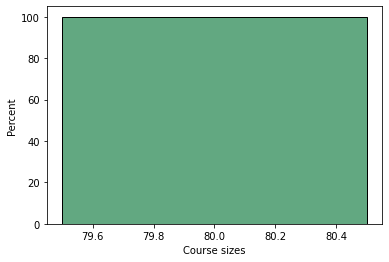

In [20]:
course_enroll_sizes = [len(c.student_enroll) for c in course_list]
sns.histplot(course_enroll_sizes, stat = 'percent', color = 'seagreen')
plt.xlabel("Course sizes")

## Sanity check

In [21]:
for c in course_list:
    for s in c.student_enroll:
        assert c.course_id in s.course_enroll
        
    assert len(c.student_enroll) <= c.enroll_limit

for s in student_list:
    assert len(s.course_enroll) <= s.credit_limit

# Course Scheduling

There are $k = 12$ time slots. Assume that rooms are unlimited.

For each course-time assignment, find the number of conflicts among students and pick the one with the minimum conflicts.

There are $k^n$ possible course-time assignments. -> NP-hard

**Maximum-weight k-cut problem**

Min weight between components, but we want max conflicts between components

Higher conflicts $c$ -> lower weights $w$

$w = -c + \max(c)$

But weights need to be positive so add $\max(c)$ 

https://en.wikipedia.org/wiki/Minimum_k-cut

https://cstheory.stackexchange.com/questions/50321/max-k-cut-with-negative-edge-weights

https://math.mit.edu/~goemans/18434S06/multicuts-brian.pdf

https://neo4j.com/docs/graph-data-science/current/algorithms/approx-max-k-cut/

https://www.math.cmu.edu/~af1p/Texfiles/cuts.pdf

https://cs.gmu.edu/~lifei/teaching/cs684_spring12/multi-cut.pdf

https://www.geeksforgeeks.org/gomory-hu-tree-introduction/#

https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.flow.gomory_hu_tree.html

https://courses.engr.illinois.edu/cs598csc/sp2009/lectures/lecture_7.pdf

In [22]:
conflict_counts = defaultdict(int)

for s in student_list:
    for c1, c2 in combinations(sorted(s.course_enroll), 2):
        conflict_counts[(c1, c2)] += 1

print(f"number of edges: {len(conflict_counts)}")

number of edges: 376


In [23]:
print(f"total number of conflicts: {sum(conflict_counts.values())}")

total number of conflicts: 10865


In [24]:
graph = nx.Graph()
graph.add_weighted_edges_from([(c[0], c[1], n * (-1) + max(conflict_counts.values())) 
                               for c, n in conflict_counts.items()])
print(f"Number of nodes: {graph.number_of_nodes()}")
print(f"Number of edges: {graph.number_of_edges()}")

Number of nodes: 99
Number of edges: 376


## Minimum-weight k-Cut Problem

Gomury-Hu approach for k-Cut$(G)$

1. Compute Gomury-Hu tree $T$ for $G$
2. Remove $k-1$ minimum weight (or lightest) edges from the Tree.
3. Return union of components obtained by above removal of edges.

Guarantee approximation ratio of $2 - \frac{2}{k}$

In [25]:
# nx.set_edge_attributes(graph, 1, "capacity")
T = nx.gomory_hu_tree(graph, capacity = 'weight')

In [26]:
# for node1, node2, data in T.edges(data = True):
#     print(f"({node1}, {node2}) with weight {data['weight']}")

In [27]:
k = 12
min_weight_k_edges = sorted([e for e in T.edges(data = True)], 
                            key = lambda x: x[2]['weight'],
                            reverse = False)[: k - 1]
for node1, node2, data in min_weight_k_edges:
    print(f"({node1}, {node2}) with weight {data['weight']}")

(72, 23) with weight 0
(50, 0) with weight 0
(92, 56) with weight 0
(91, 3) with weight 0
(68, 9) with weight 0
(26, 97) with weight 0
(39, 43) with weight 0
(55, 13) with weight 0
(33, 17) with weight 0
(80, 45) with weight 0
(48, 19) with weight 0


In [28]:
T.remove_edges_from(min_weight_k_edges)
components = list(nx.connected_components(T))
print(f"Number of components: {len(components)}")
for i, comp in enumerate(components):
    print(f"Component {i}: size = {len(comp)} -> {list(comp)}")

Number of components: 12
Component 0: size = 10 -> [8, 72, 40, 11, 44, 88, 60, 93, 30, 31]
Component 1: size = 6 -> [96, 66, 10, 50, 51, 23]
Component 2: size = 16 -> [0, 32, 65, 4, 73, 75, 81, 18, 52, 21, 54, 86, 24, 57, 92, 25]
Component 3: size = 8 -> [2, 99, 38, 79, 15, 56, 91, 94]
Component 4: size = 5 -> [3, 68, 5, 74, 16]
Component 5: size = 9 -> [97, 71, 9, 42, 41, 20, 53, 61, 63]
Component 6: size = 5 -> [39, 76, 83, 26, 28]
Component 7: size = 8 -> [43, 77, 85, 22, 87, 55, 59, 62]
Component 8: size = 10 -> [33, 37, 6, 13, 14, 46, 84, 58, 29, 95]
Component 9: size = 5 -> [7, 80, 17, 82, 27]
Component 10: size = 5 -> [64, 1, 45, 48, 89]
Component 11: size = 12 -> [98, 35, 67, 69, 70, 34, 36, 12, 78, 47, 19, 90]


In [29]:
# cutset = set()
# U = components[0]
# V = components[2]
# for x, nbrs in ((n, graph[n]) for n in U):
#     cutset.update((x, y) for y in nbrs if y in V)
   
# print(f"size of cutset: {len(cutset)}")
# cutset

### Assign time to courses and resolve conflicts among students

In [30]:
for t, c_list in enumerate(components):
    for c in list(c_list):
        course_list[c].set_time(t)

for s in student_list:
    s.determine_conflicts(course_list)

In [31]:
student_list, course_list = resolve_conflicts(student_list, course_list)

Round: 1
	Number of proposals made: 17650
	Number of proposals being rejected: 17404
Round: 2
	Number of proposals made: 17404
	Number of proposals being rejected: 17187
Round: 3
	Number of proposals made: 17187
	Number of proposals being rejected: 16956
Round: 4
	Number of proposals made: 16956
	Number of proposals being rejected: 16736
Round: 5
	Number of proposals made: 16736
	Number of proposals being rejected: 16502
Round: 6
	Number of proposals made: 16502
	Number of proposals being rejected: 16261
Round: 7
	Number of proposals made: 16261
	Number of proposals being rejected: 16023
Round: 8
	Number of proposals made: 16023
	Number of proposals being rejected: 15812
Round: 9
	Number of proposals made: 15812
	Number of proposals being rejected: 15597
Round: 10
	Number of proposals made: 15597
	Number of proposals being rejected: 15357
Round: 11
	Number of proposals made: 15357
	Number of proposals being rejected: 15126
Round: 12
	Number of proposals made: 15126
	Number of proposals

In [32]:
# sanity checks
for c in course_list:
    for s in c.student_enroll:
        assert c.course_id in s.course_enroll
        
    assert len(c.student_enroll) <= c.enroll_limit

for s in student_list:
    assert len(s.course_enroll) <= s.credit_limit

In [33]:
# for s in student_list:
#     s.get_enrollment_info()
# for c in course_list:
#     c.get_enrollment_info()

Text(0.5, 0, 'Student utiltities')

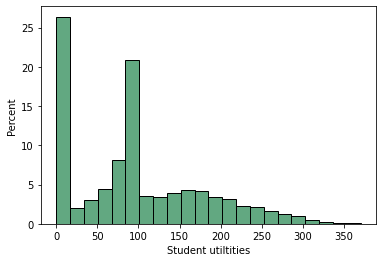

In [34]:
student_utilities = [s.get_utilities() for s in student_list]
total_welfare = sum(student_utilities)
sns.histplot(student_utilities, stat = 'percent', color = 'seagreen')
plt.xlabel("Student utiltities")

Text(0.5, 0, 'Course sizes')

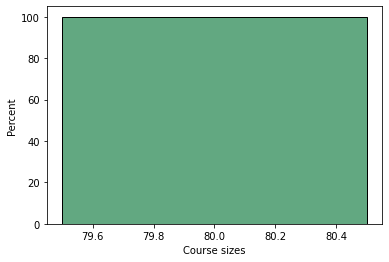

In [35]:
course_enroll_sizes = [len(c.student_enroll) for c in course_list]
sns.histplot(course_enroll_sizes, stat = 'percent', color = 'seagreen')
plt.xlabel("Course sizes")

# Baseline: traditional approach